In [1]:
import os
import matplotlib.pyplot as plt

# for font embedding things
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)

save_dir = os.path.join(fig_dir, "mc_conf")
os.makedirs(save_dir, exist_ok=True)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

spoof_color = "#FF474C"
benign_color = "#228B22"

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams["font.family"] = "serif"
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import os
import torch
from utils import get_datasets, get_models, get_title_mappings


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# load in the datasets
CSM, datasets = get_datasets(device=device, split="test")

# load in the models
models = get_models(device=device)
model_titles, adv_titles = get_title_mappings()

# set up paths for saving
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/unet/model_20240911_173745/epoch_8.pth
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/unet_mc/model_20240915_210142/epoch_9.pth
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/unet_adversarial/model_20240911_170545/epoch_8.pth
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/une

In [3]:
cmap_binary = "gray"
cmap_conf = "plasma"
cmap_adv = "inferno"

# get some instances of attacks
idxs_attack = [
    idx for idx in range(100) if datasets["adversarial"].get_metadata(idx)["attacked"]
]
idxs_attack_uniform = [
    idx
    for idx in idxs_attack
    if datasets["adversarial"].get_metadata(idx)["attacked"]
    and datasets["adversarial"].get_metadata(idx)["adv_model"] == "uniform"
]
idxs_show = [idxs_attack_uniform[i] for i in [3, 7, 30, 60]]

## Visualize models on adversarial and benign datasets

Showing benign dataset
Frame attacked: False, attack type: none, n points: 0


/home/spencer/.cache/pypoetry/virtualenvs/fov-security-pWvESQ_k-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


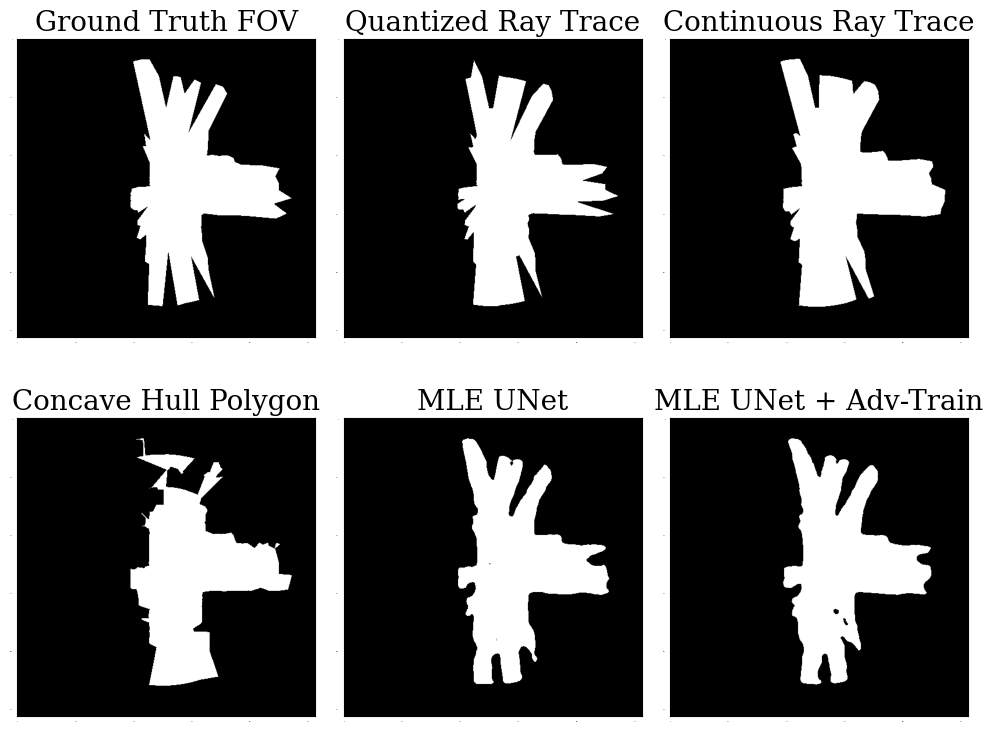

Frame attacked: False, attack type: none, n points: 0


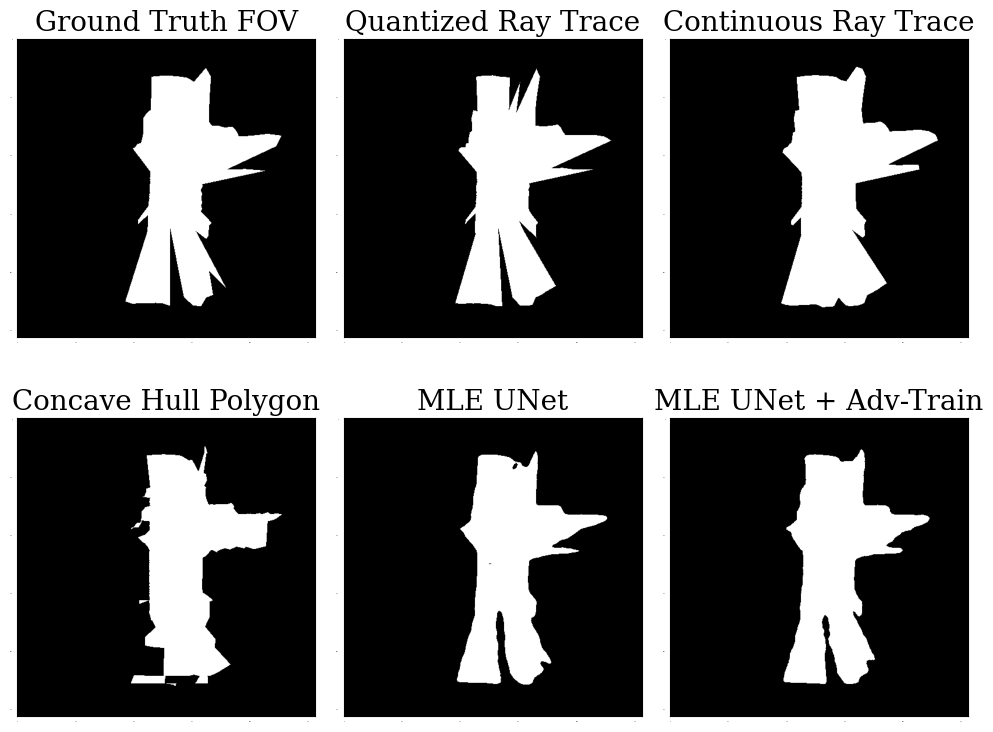

Frame attacked: False, attack type: none, n points: 0


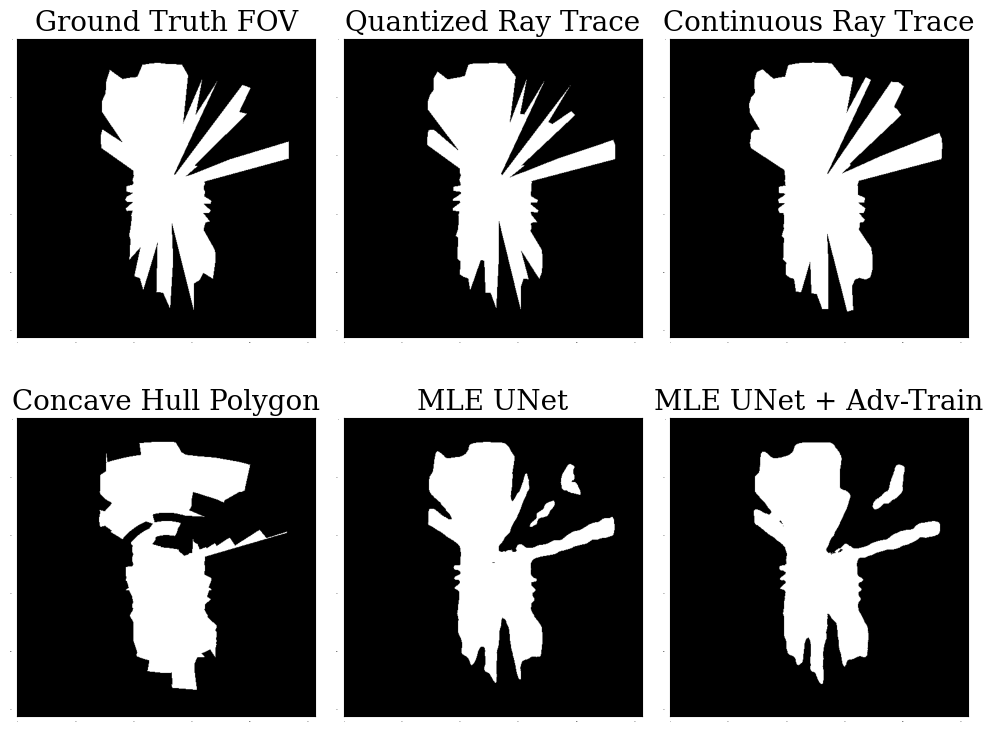

Frame attacked: False, attack type: none, n points: 0


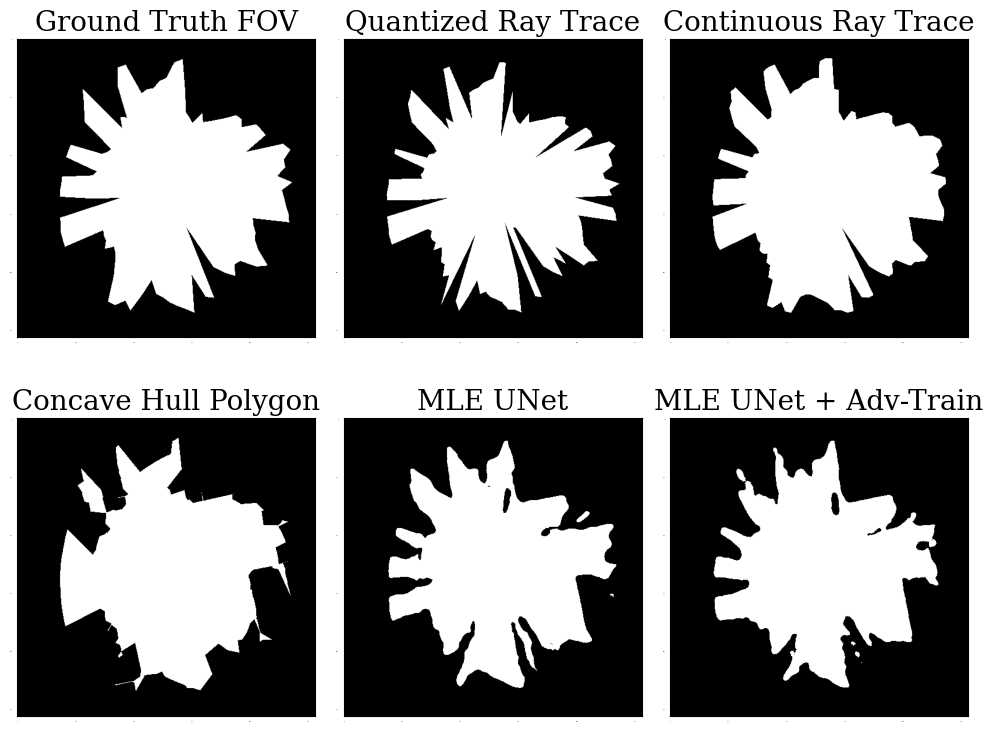

Showing adversarial dataset
Frame attacked: True, attack type: uniform, n points: 101


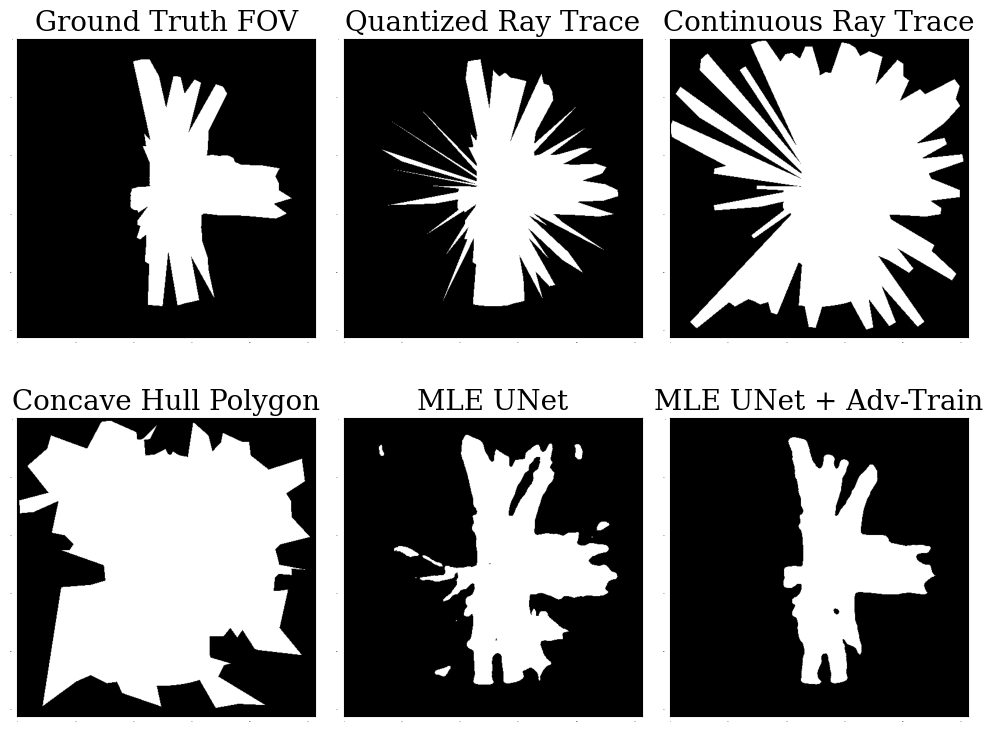

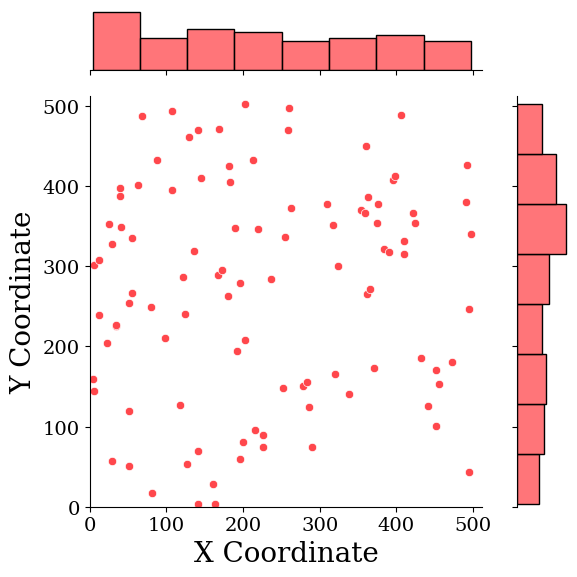

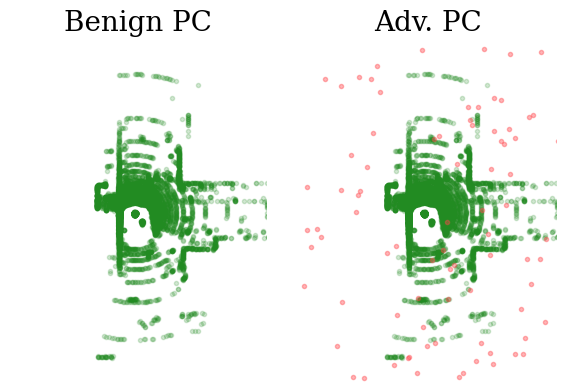

Frame attacked: True, attack type: uniform, n points: 108


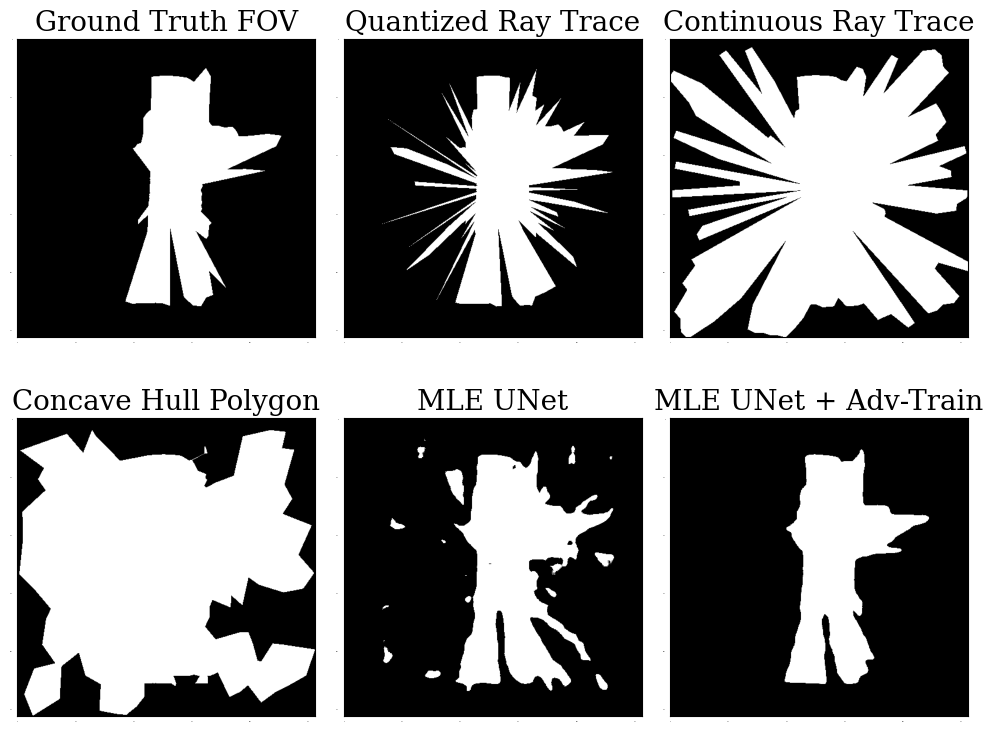

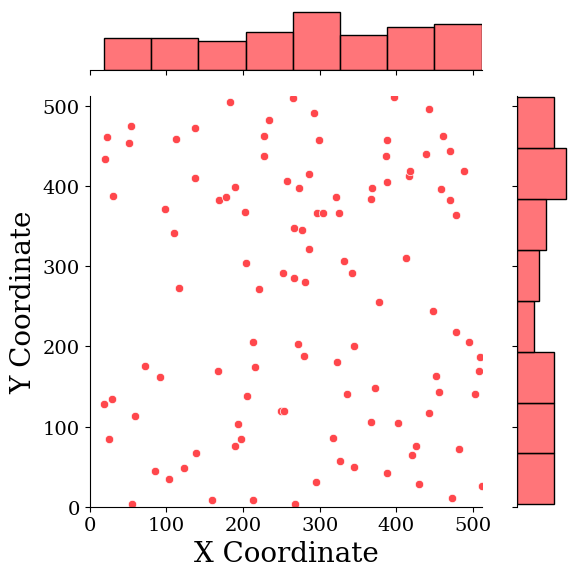

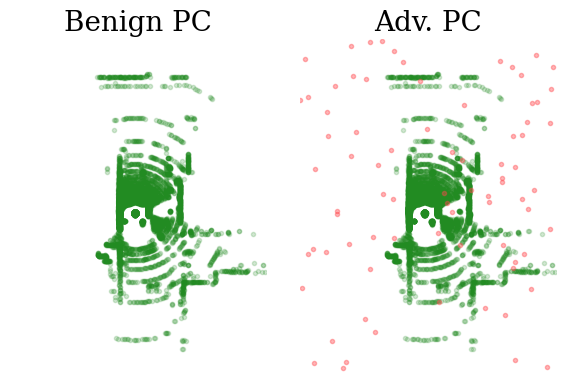

Frame attacked: True, attack type: uniform, n points: 88


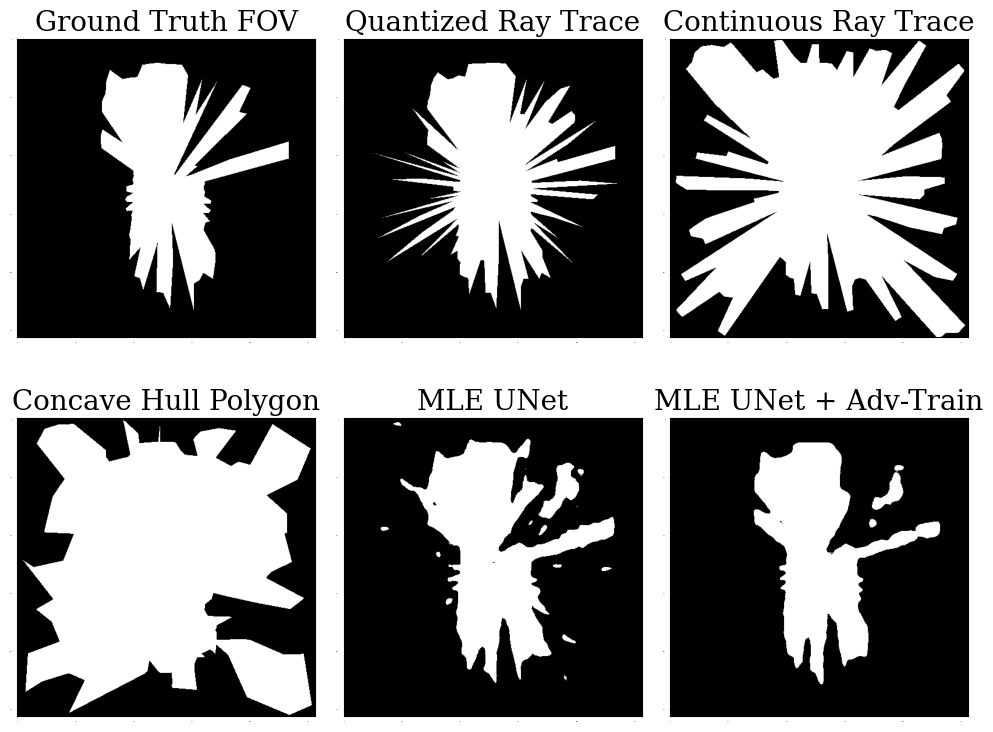

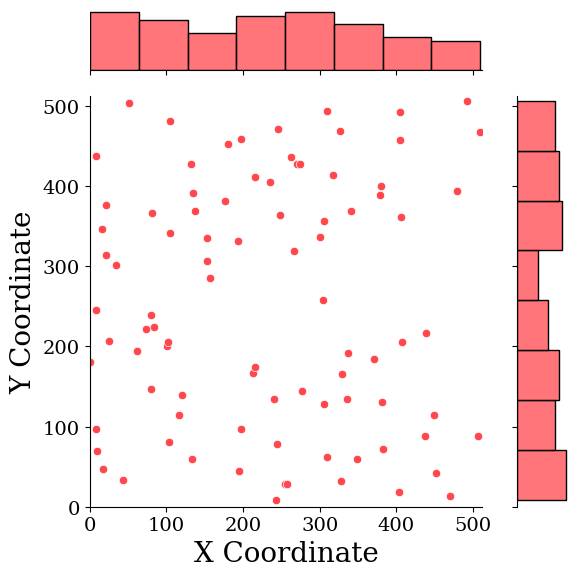

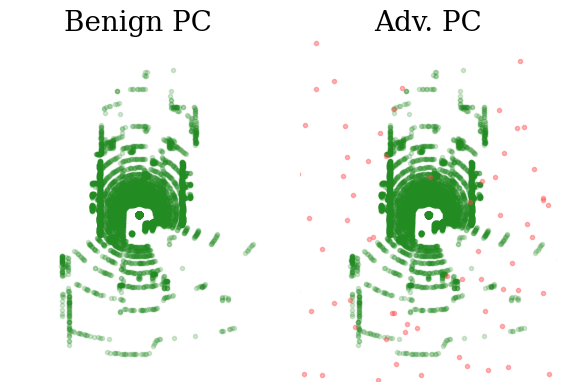

Frame attacked: True, attack type: uniform, n points: 117


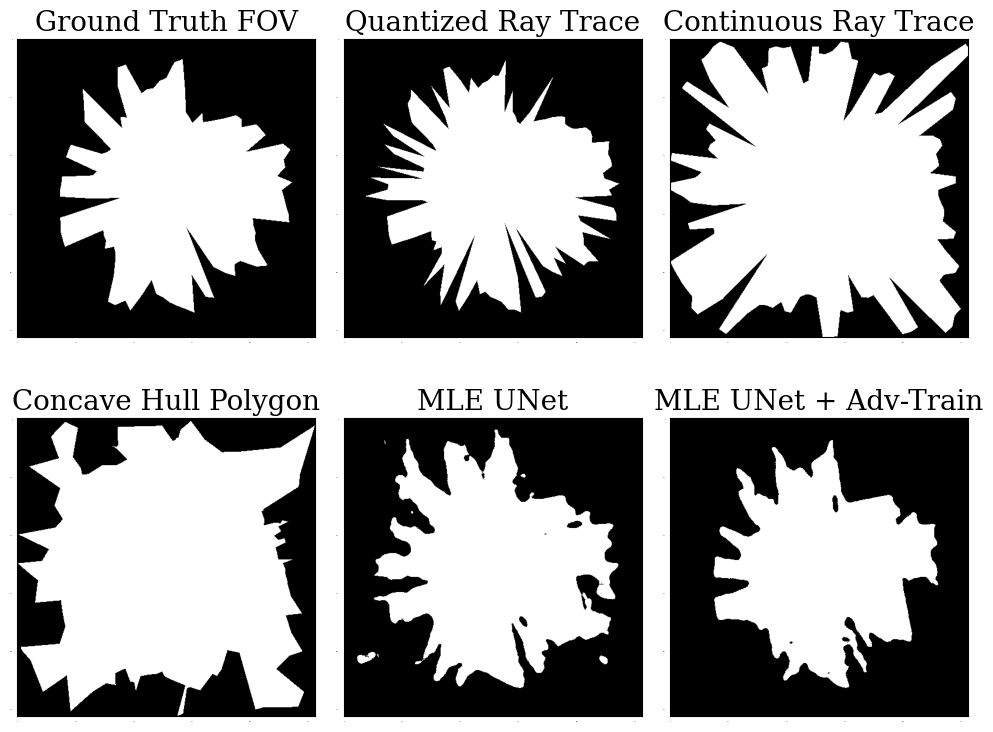

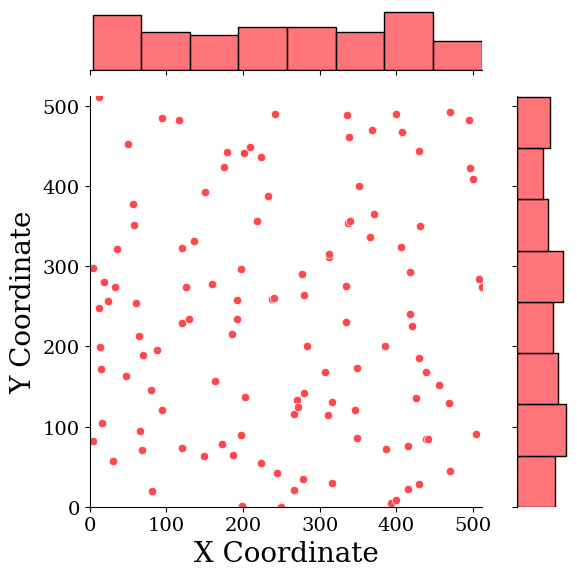

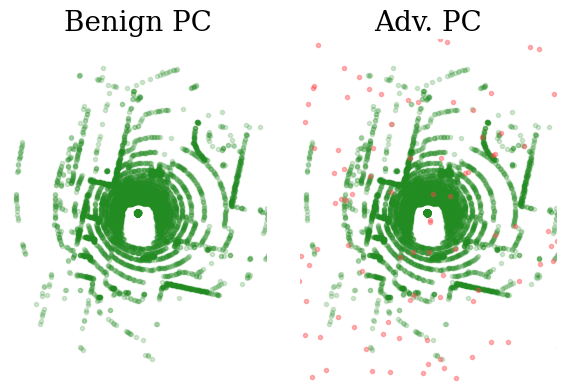

In [4]:
import seaborn as sns


# get the predictions for frames
for dataset_name, dataset in datasets.items():
    print(f"Showing {dataset_name} dataset")
    for idx in idxs_show:
        # get data
        pc_img, gt_mask = dataset[idx]
        pc_img = torch.unsqueeze(pc_img, 0)
        pc_np = dataset.get_pointcloud(idx)
        metadata = dataset.get_metadata(idx)
        print(
            f"Frame attacked: {metadata['attacked']}, attack type: {metadata['adv_model']}, n points: {metadata['n_pts_adv']}"
        )

        # apply models
        pc_img_maps = {
            model_name: model(pc_img, pc_np, metadata).detach().cpu().squeeze()
            for model_name, model in models.items()
        }
        pc_img_maps["gt"] = gt_mask.detach().cpu().squeeze()

        # visualize the result
        fig, axs = plt.subplots(2, 3, figsize=(10, 8))
        model_names = [
            "gt",
            "fast_ray_trace",
            "slow_ray_trace",
            "concave_hull",
            "unet",
            "unet_adversarial",
        ]
        threshold = 0.7
        for ax, model_name in zip(axs.flatten(), model_names):
            if model_name is None:
                continue
            ax.imshow(pc_img_maps[model_name] > threshold, cmap=cmap_binary)
            ax.tick_params(which="both", size=0, labelsize=0)
            ax.set_title(model_titles[model_name], size=20)

        plt.tight_layout()
        save_path = os.path.join(
            save_dir, "segout_{}_frame_{}.{}".format(dataset_name, idx, "{}")
        )
        plt.savefig(save_path.format("png"))
        plt.savefig(save_path.format("pdf"))
        plt.show()

        # make the sns jointplot of attack distribution
        if "adversarial" in dataset_name:
            # -- spoofed point distribution
            pc_img_benign, _ = datasets["benign"][idx]
            pc_img_benign = torch.unsqueeze(pc_img_benign, 0)
            pc_img_adv, _ = datasets["adversarial"][idx]
            pc_img_adv = torch.unsqueeze(pc_img_adv, 0)
            spoof_img = (pc_img_adv - pc_img_benign).squeeze().cpu()
            x_pts, y_pts = torch.where(spoof_img)
            h = sns.jointplot(
                x=x_pts,
                y=y_pts,
                kind="scatter",
                xlim=[0, 512],
                ylim=[0, 512],
                color=spoof_color,
            )
            h.set_axis_labels("X Coordinate", "Y Coordinate", fontsize=20)
            h.figure.tight_layout()
            save_path = os.path.join(
                save_dir, "segout_jointplot_frame_{}.{}".format(idx, "{}")
            )
            h.savefig(save_path.format("png"))
            h.savefig(save_path.format("pdf"))

            # -- plot the lidar point cloud in BEV
            pc_benign = datasets["benign"].get_pointcloud(idx)
            pc_adv = datasets["adversarial"].get_pointcloud(idx)
            fig, axs = plt.subplots(1, 2, figsize=(6, 4))
            for i, (ax, pc, title) in enumerate(
                zip(axs, [pc_benign, pc_adv], ["Benign PC", "Adv. PC"])
            ):
                if i == 0:
                    # for benign, only plot regular points
                    ax.scatter(
                        pc[:, 1], pc[:, 0], marker=".", alpha=0.2, color=benign_color
                    )
                else:
                    # for adv mark additional spoof points in red
                    ax.scatter(
                        pc[: len(pc_benign), 1],
                        pc[: len(pc_benign), 0],
                        marker=".",
                        alpha=0.2,
                        color=benign_color,
                    )
                    ax.scatter(
                        pc[len(pc_benign) :, 1],
                        pc[len(pc_benign) :, 0],
                        marker=".",
                        alpha=0.4,
                        color=spoof_color,
                    )

                ax.set_xlim([-60, 60])
                ax.set_ylim([-80, 80])
                ax.set_aspect("equal")
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(title, size=20)
                ax.axis("off")

            plt.tight_layout()
            save_path = os.path.join(
                save_dir, "segout_pointcloud_frame_{}.{}".format(idx, "{}")
            )
            plt.savefig(save_path.format("png"))
            plt.savefig(save_path.format("pdf"))
            plt.show()

## Visualize results of MC dropout

Dataset: benign, model: unet_mc, frame: 10


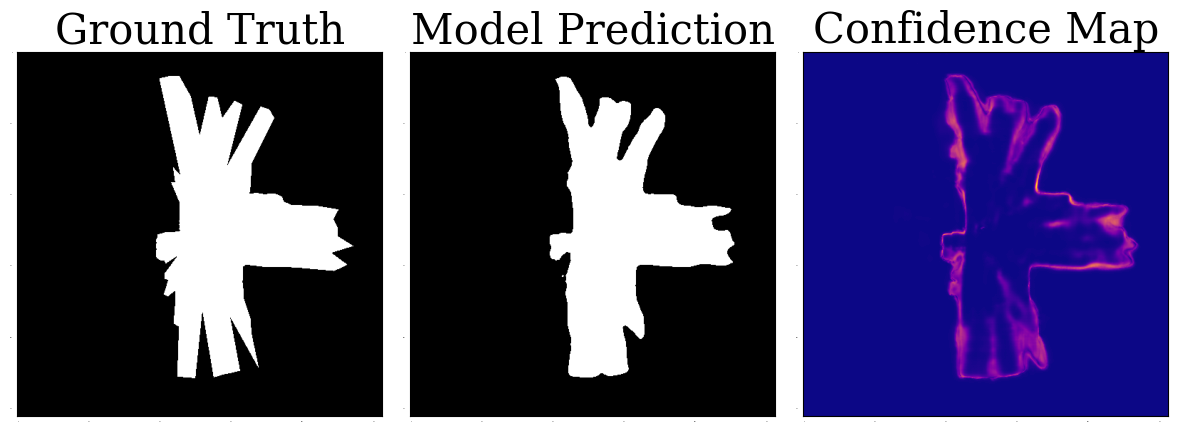

Dataset: benign, model: unet_mc_adversarial, frame: 10


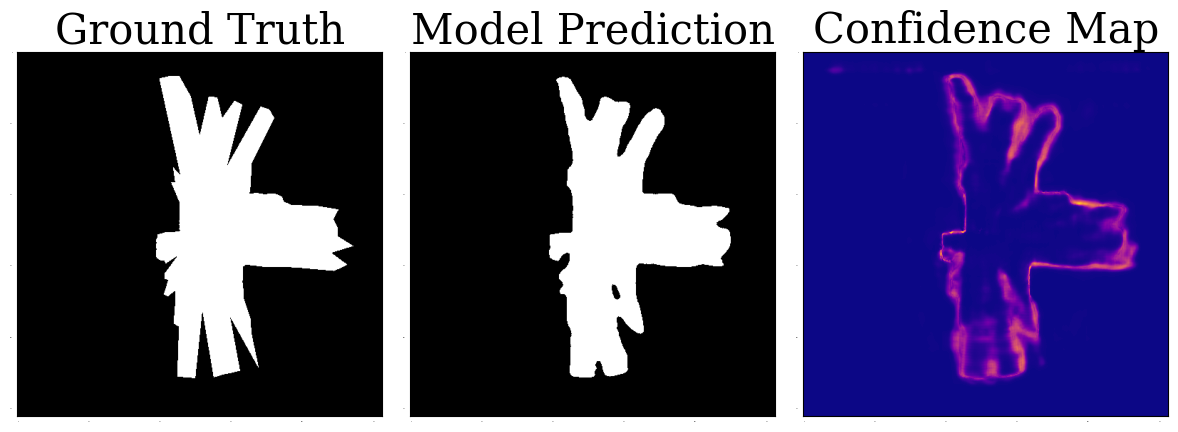

Dataset: adversarial, model: unet_mc, frame: 10


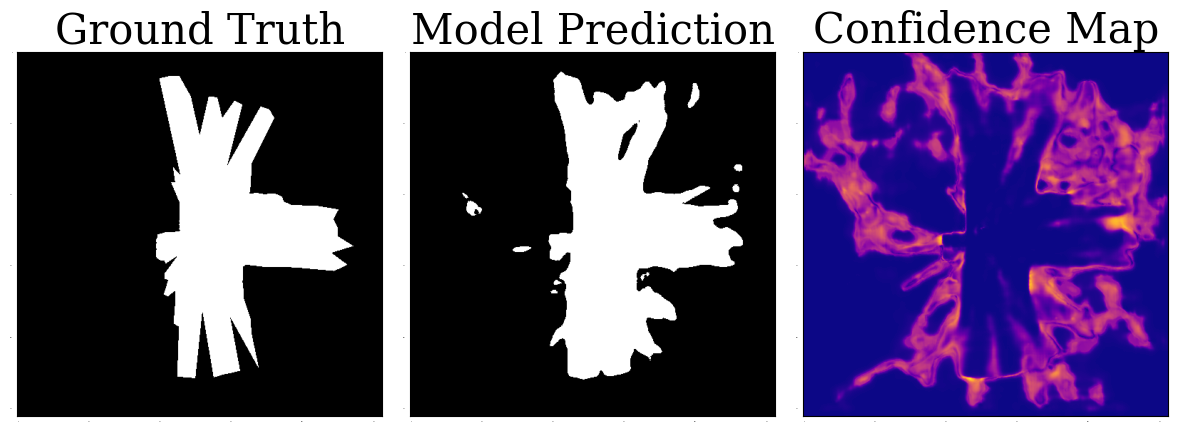

Dataset: adversarial, model: unet_mc_adversarial, frame: 10


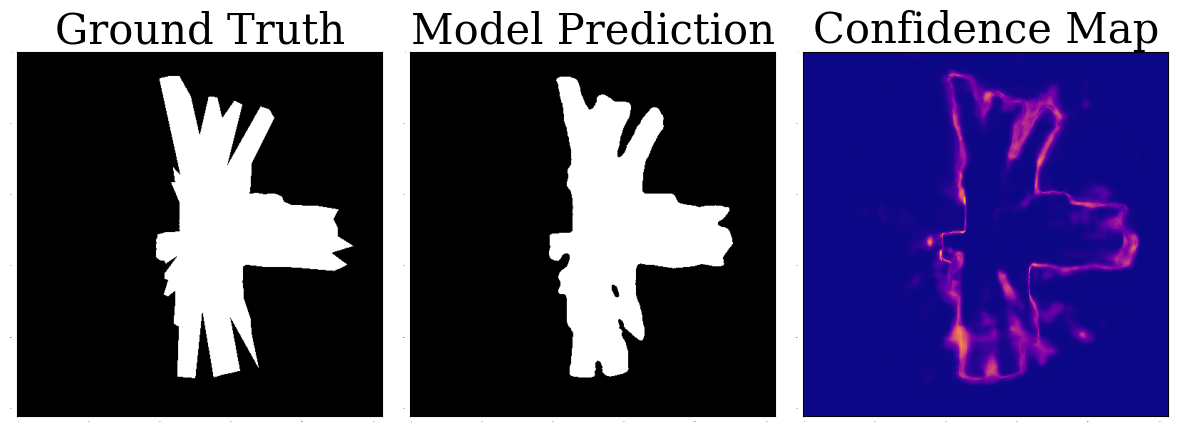

Dataset: benign, model: unet_mc, frame: 14


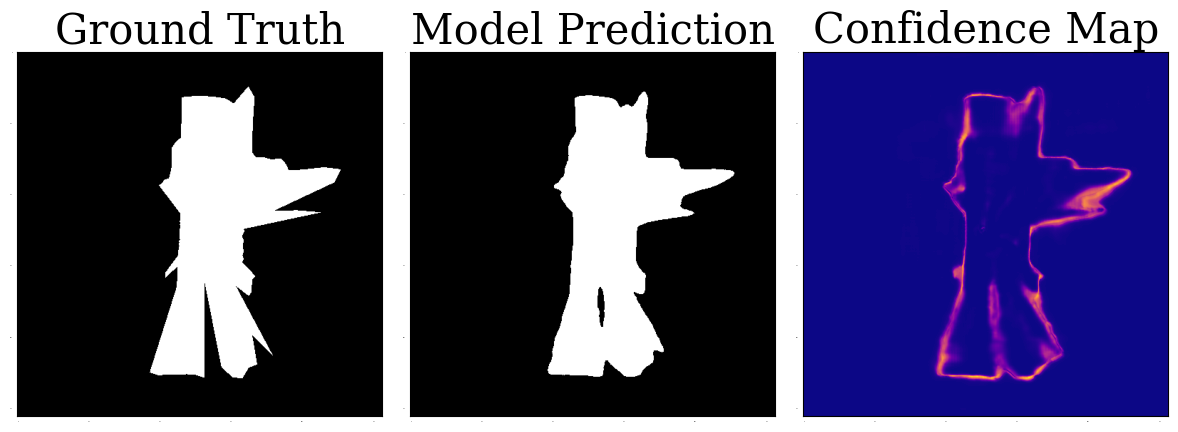

Dataset: benign, model: unet_mc_adversarial, frame: 14


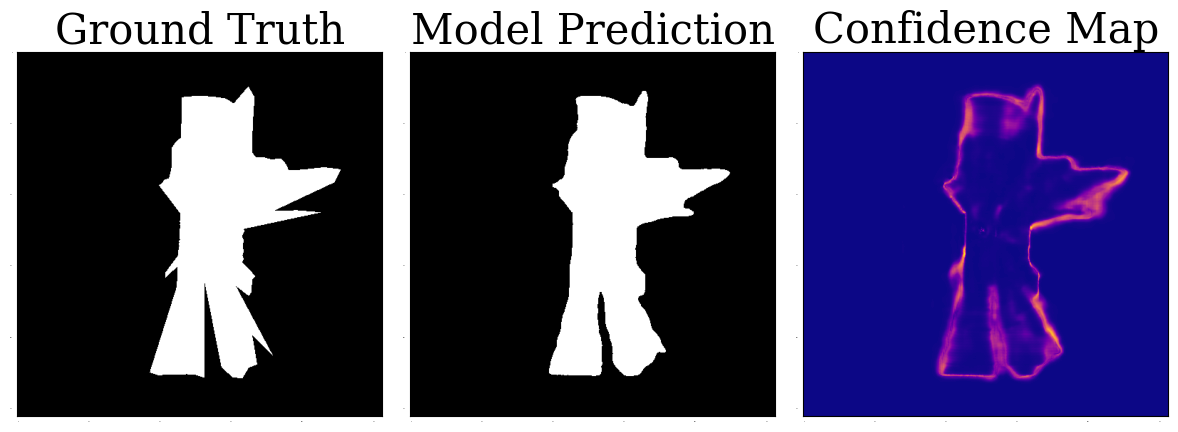

Dataset: adversarial, model: unet_mc, frame: 14


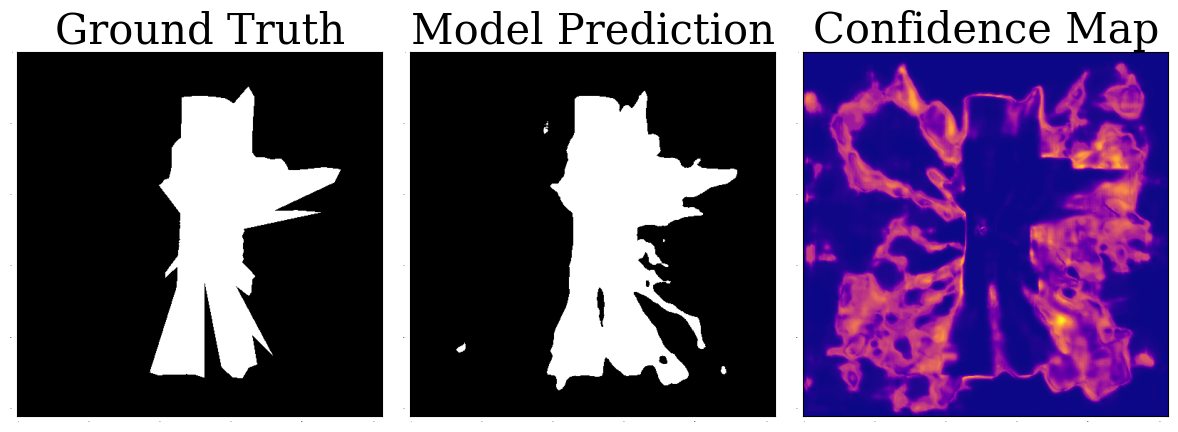

Dataset: adversarial, model: unet_mc_adversarial, frame: 14


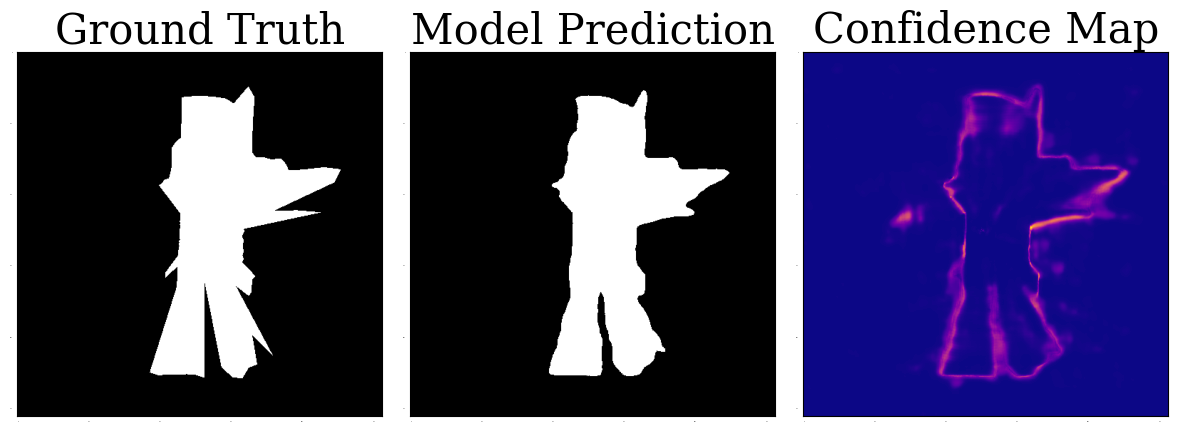

Dataset: benign, model: unet_mc, frame: 45


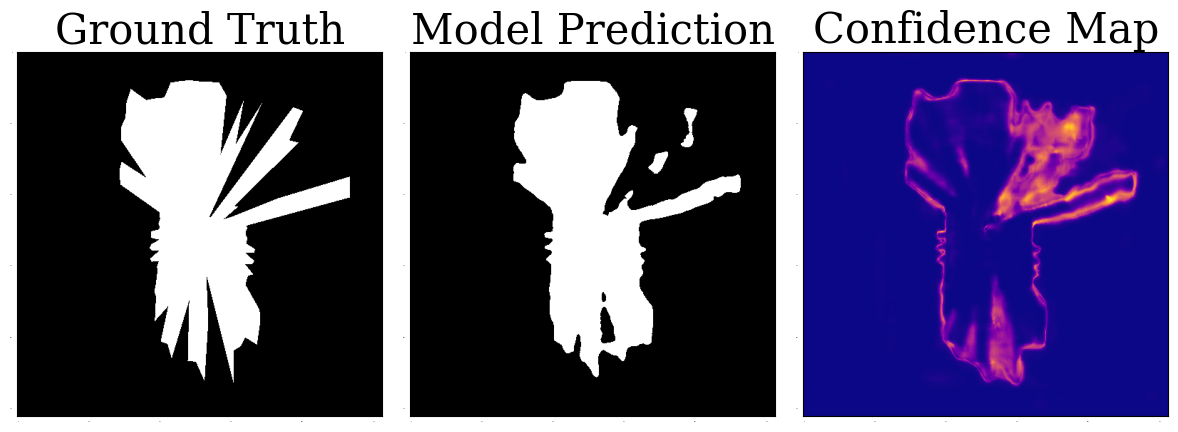

Dataset: benign, model: unet_mc_adversarial, frame: 45


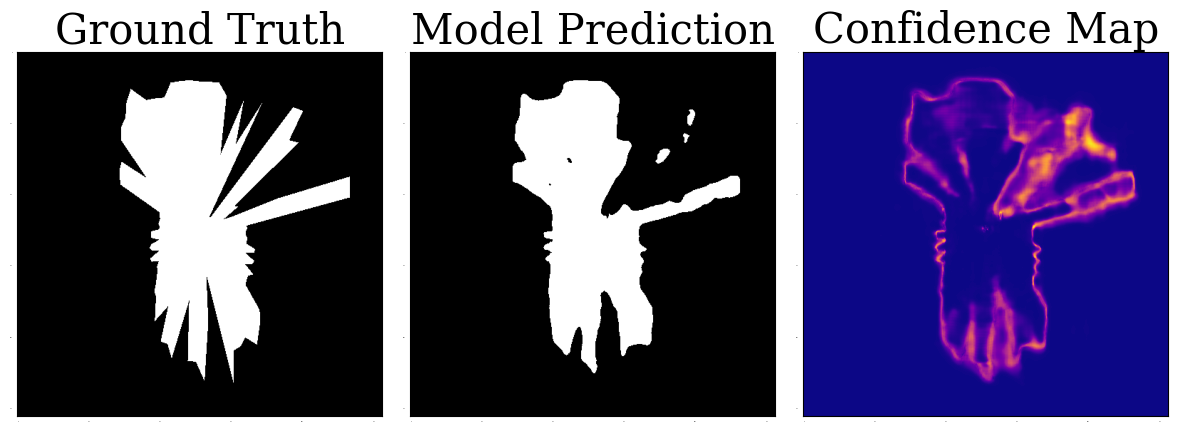

Dataset: adversarial, model: unet_mc, frame: 45


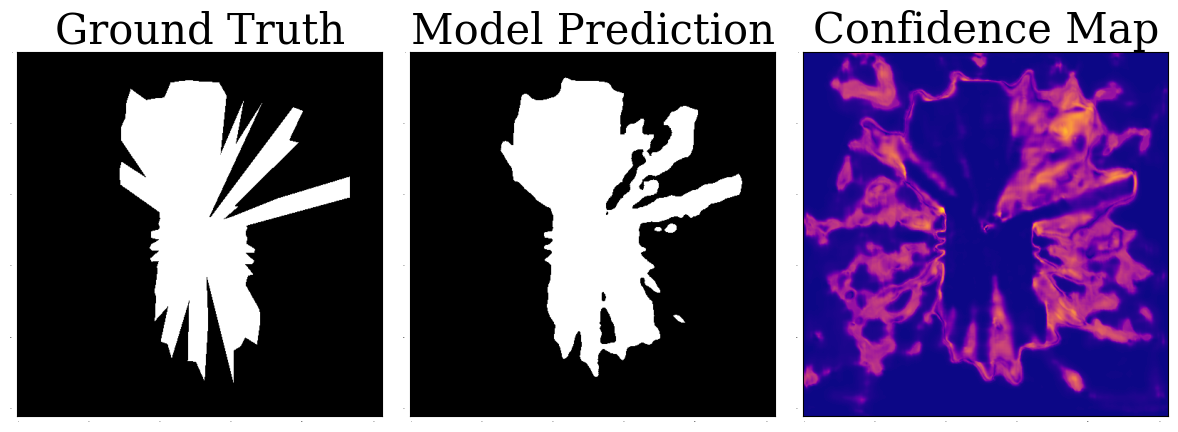

Dataset: adversarial, model: unet_mc_adversarial, frame: 45


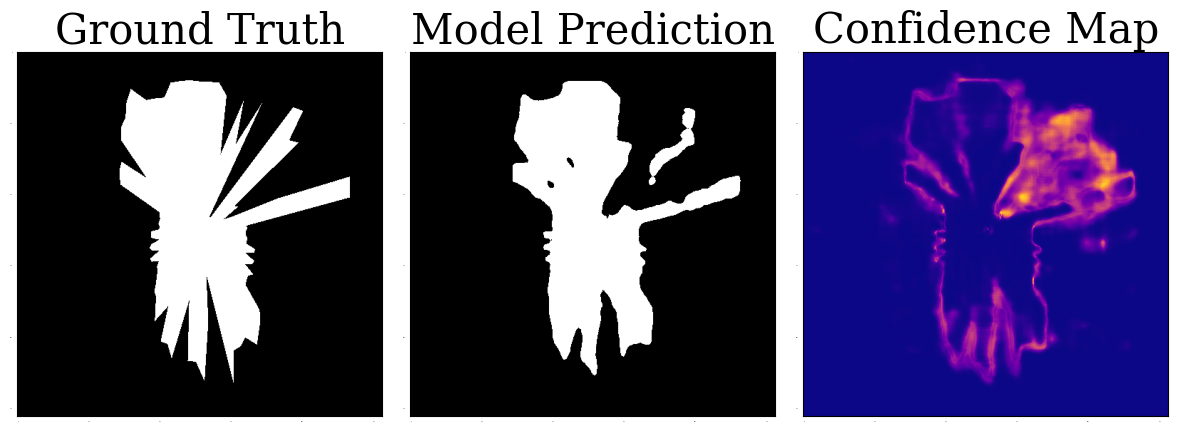

Dataset: benign, model: unet_mc, frame: 99


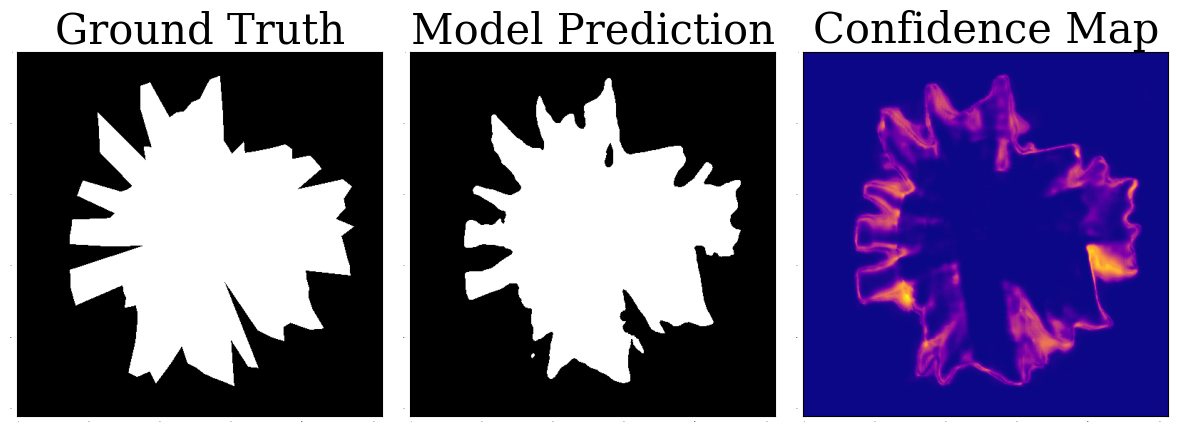

Dataset: benign, model: unet_mc_adversarial, frame: 99


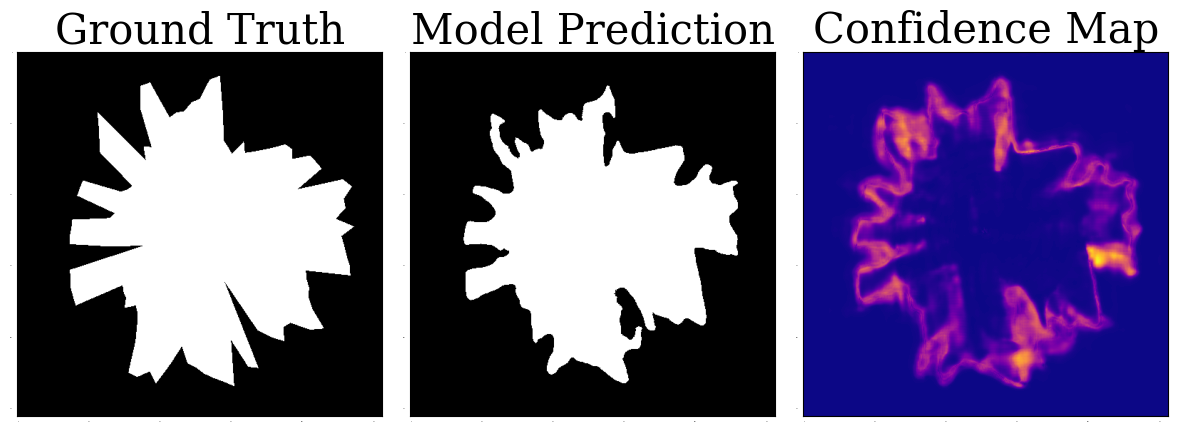

Dataset: adversarial, model: unet_mc, frame: 99


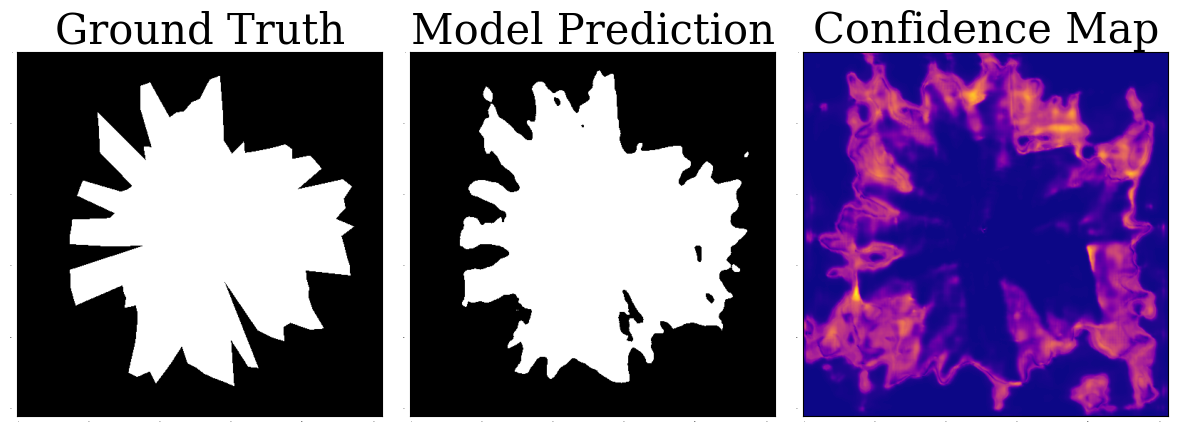

Dataset: adversarial, model: unet_mc_adversarial, frame: 99


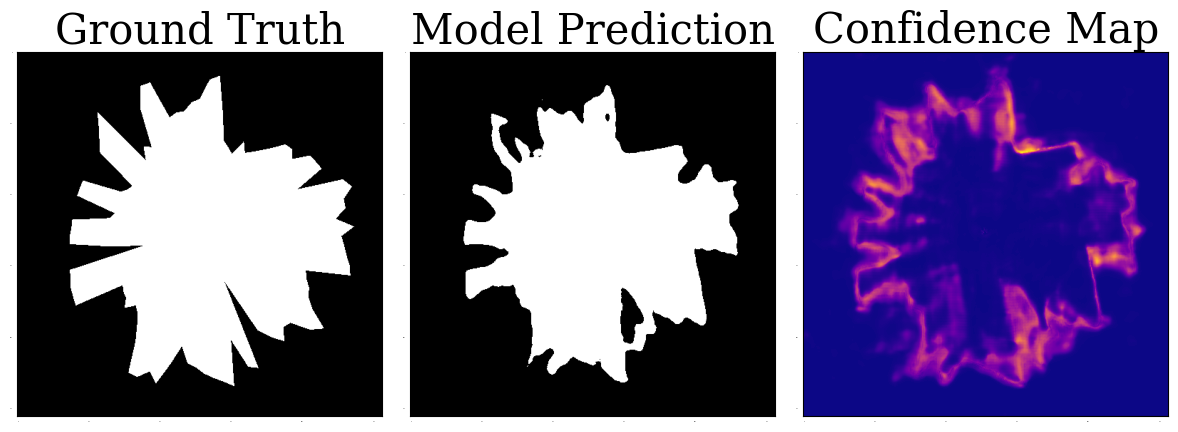

In [5]:
cmap_binary = "gray"
cmap_conf = "plasma"

# loop over models
for idx in idxs_show:
    for dataset_name, dataset in datasets.items():
        for model_name in ["unet_mc", "unet_mc_adversarial"]:
            seg_model = models[model_name]
            fig, axs = plt.subplots(1, 3, figsize=(12, 6))

            # print out status
            print(f"Dataset: {dataset_name}, model: {model_name}, frame: {idx}")

            # run MC prediction on an image
            pc_img, gt_mask = datasets[dataset_name][idx]
            pc_img = pc_img.unsqueeze(0)
            mask_bin, mask_mean, mask_std = seg_model.model.predict_mc_dropout(
                pc_img, n_iters=10, threshold=0.7
            )

            # set up the tuples for loops
            titles = ["Ground Truth", "Model Prediction", "Confidence Map"]
            cmaps = [cmap_binary, cmap_binary, cmap_conf]
            masks = [gt_mask, mask_bin, mask_std]

            # add the masks to plots
            for ax, title, cmap, mask in zip(axs, titles, cmaps, masks):
                ax.imshow(mask.squeeze().cpu(), cmap=cmap)
                ax.tick_params(which="both", size=0, labelsize=0)
                ax.set_title(title, size=30)

            # save figure
            plt.tight_layout()
            save_path = os.path.join(
                save_dir,
                "mc_conf_dataset_{}_model_{}_frame_{}.{}".format(
                    dataset_name, model_name, idx, "{}"
                ),
            )
            plt.savefig(save_path.format("png"))
            plt.savefig(save_path.format("pdf"))
            plt.show()

## Make a particular MCD figure

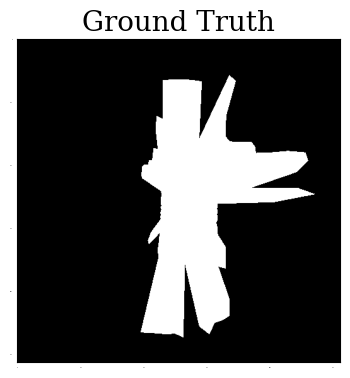

Dataset: benign, model: unet_mc, frame: 13
Dataset: adversarial, model: unet_mc, frame: 13
Dataset: benign, model: unet_mc_adversarial, frame: 13
Dataset: adversarial, model: unet_mc_adversarial, frame: 13


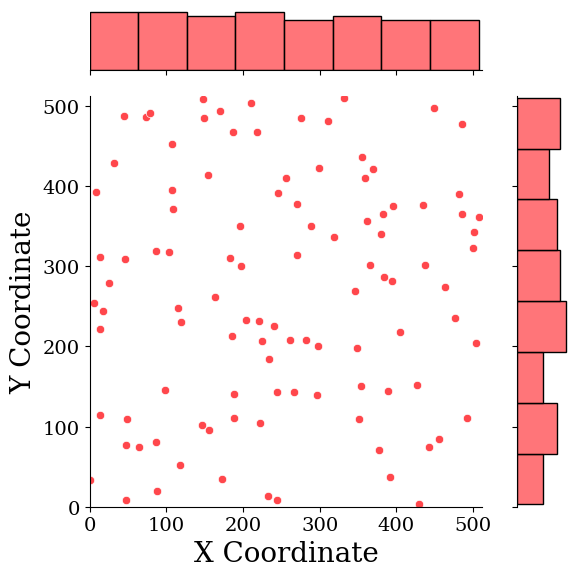

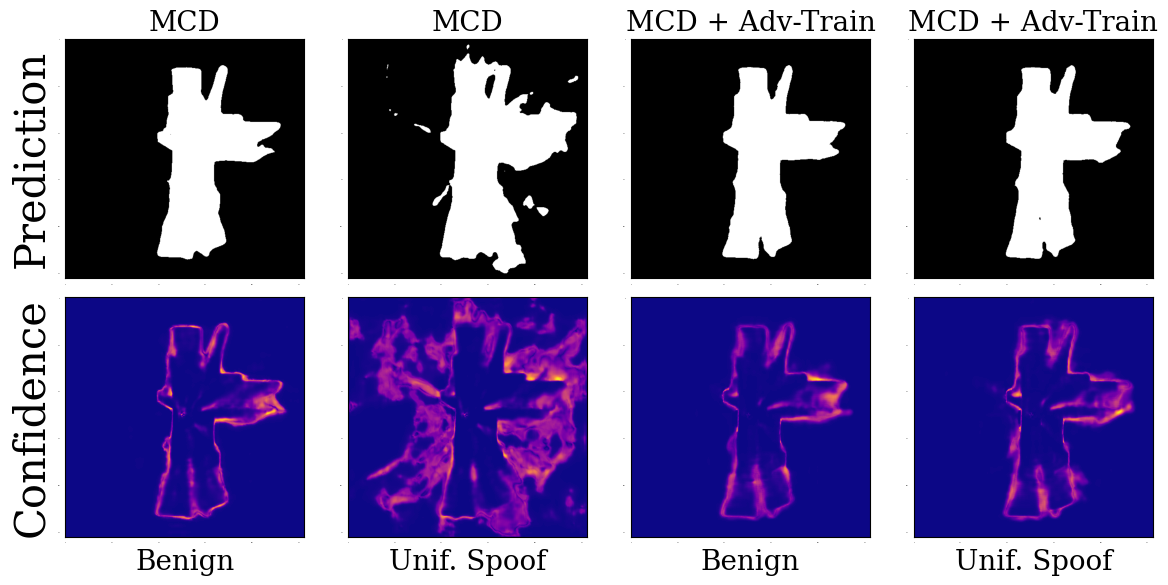

In [6]:
import seaborn as sns


idx_show = idxs_attack_uniform[6]
model_name_mods = {
    "unet_mc": "MCD",
    "unet_mc_adversarial": "MCD + Adv-Train",
}

dataset_mod = {
    "benign": "Benign",
    "adversarial": "Unif. Spoof",
}


# first plot is the ground truth and spoof profile
pc_img_benign, gt_mask_benign = datasets["benign"][idx_show]
pc_img_adv, _ = datasets["adversarial"][idx_show]

# -- ground truth
fig, ax_gt = plt.subplots(1, 1, figsize=(4, 4))
ax_gt.imshow(gt_mask_benign.squeeze().cpu(), cmap=cmap_binary)
ax_gt.tick_params(which="both", size=0, labelsize=0)
ax_gt.set_title("Ground Truth", size=20)
plt.tight_layout()
save_path = os.path.join(save_dir, "TRUTH_mc_conf_frame_{}.{}".format(idx_show, "{}"))
plt.savefig(save_path.format("png"))
plt.savefig(save_path.format("pdf"))
plt.show()

# -- spoofed point distribution
spoof_img = (pc_img_adv - pc_img_benign).squeeze().cpu()
x_pts, y_pts = torch.where(spoof_img)
h = sns.jointplot(
    x=x_pts,
    y=y_pts,
    kind="scatter",
    xlim=[0, 512],
    ylim=[0, 512],
    color=spoof_color,
)
h.set_axis_labels("X Coordinate", "Y Coordinate", fontsize=20)
h.figure.tight_layout()
save_path = os.path.join(save_dir, "JOINT_mc_conf_frame_{}.{}".format(idx_show, "{}"))
h.savefig(save_path.format("png"))
h.savefig(save_path.format("pdf"))

# remaining columns are the models
titles = ["Prediction", "Confidence"]
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
jcol = 0
for model_name in ["unet_mc", "unet_mc_adversarial"]:
    for dataset_name in ["benign", "adversarial"]:
        # print out status
        print(f"Dataset: {dataset_name}, model: {model_name}, frame: {idx_show}")

        # get the appropriate model
        seg_model = models[model_name]

        # run MC prediction on an image
        pc_img, gt_mask = datasets[dataset_name][idx_show]
        pc_img = pc_img.unsqueeze(0)
        mask_bin, mask_mean, mask_std = seg_model.model.predict_mc_dropout(
            pc_img, n_iters=10, threshold=0.5
        )

        # set up the tuples for loops
        ylabel_firsts = ["Prediction", "Confidence"]
        cmaps = [cmap_binary, cmap_conf]
        masks = [mask_bin, mask_std]

        # add the masks to plots
        for irow, (ax, title, cmap, mask) in enumerate(
            zip([axs[0, jcol], axs[1, jcol]], titles, cmaps, masks)
        ):
            ax.imshow(mask.squeeze().cpu(), cmap=cmap)
            ax.tick_params(which="both", size=0, labelsize=0)
            if irow == 0:
                ax.set_title(model_name_mods[model_name], size=20)
            if irow == 1:
                ax.set_xlabel(dataset_mod[dataset_name], size=20)
            if jcol == 0:
                ax.set_ylabel(title, size=30)
        jcol += 1

# save figure
plt.tight_layout()
save_path = os.path.join(
    save_dir, "AGGREGATE_mc_conf_frame_{}.{}".format(idx_show, "{}")
)
plt.savefig(save_path.format("png"))
plt.savefig(save_path.format("pdf"))
plt.show()

In [7]:
save_dir

'figures/mc_conf'